<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 32
testBlockSize = 400
numVars = 1
numYs = 1
numPoints = 250
target = 'Skeleton'
const_range = [-2.1, 2.1]
trainRange = [-3.0, 3.0]
decimals = 8
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "1_var_dataset"

In [5]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [6]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 498795 examples, 27 unique.
id:79400
outputs:C*log(C*x1)+C>_____________________
variables:1


In [7]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 967 examples, 27 unique.
tensor(-38.7744) tensor(316.4150)
id:915
outputs:C*x1**3+C*x1**2+C*x1+C*exp(C*x1)+C>_____
variables:1


In [11]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton



            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                continue
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                continue
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [9]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: -1.4608810703863337*exp(-1.3662906591107051*x1/(1.6570892466721525*x1))+-0.5481326790673482
Predicted: 1.0*x1(1.0
Err:1572.7191210998876
----------

Target: 0.9397283929441147*exp(-1.7138582239614426*x1)*-2.0077425853788546*cos(-1.3353942241925272*x1**2+-0.9402324542557938*x1)+0.7279997618628564
Predicted: 0.07480935262379557*x1**4+0.04847235932180939
Err:275.659828471845
----------

Target: 0.5035538309121157*x1**5+-1.7880275308333555*x1**4+1.9763031036747143*x1**3+0.64126273976877*x1**2*1.9018843748420244*log(0.8634365809569955*x1)+-1.6578296868442013*x1**2+-0.4515420744032035*x1+1.133184078275951
Predicted: 5.545538312280292e-06*x1**14.18212634168974+0.15891209457959732
Err:166102.80849276858
----------

Target: 0.25685479717362014*x1/(1.3240180394403067*x1+-0.16002606291656596)+1.3023923419772578
Predicted: 1.0*x1(1.0
Err:1182.6287726432338
----------

Target: 0.9633718254570423*x1*1.9148717606989867*log(0.9006877952636358*x1**4+1.6669653267307702*x1**3+0.5648574464503451*

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.8039233324116555*sin(-1.9422179572307248*x1+-1.9662808031225045)+0.6866482086467736
Predicted: 1.0*x1(1.0
Err:1763.7496979537334
----------

Target: 0.7327698426594016*log(-0.10635256807082971*x1)+-1.1759233344292421
Predicted: 1.0*x1(1.0*x1(1.0*x1+1.0))+1.0
Err:1561.9206894726992
----------

Target: 1.1759017274683217*exp(0.06394851684398883*cos(1.7635655175453762*x1))+0.14010923701375155
Predicted: 1.0*x1(1.0
Err:1315.759254507452
----------

Target: 0.47712036719067097*cos(0.582418601169866*exp(-1.0861639159147434*x1))+1.9053186552409493
Predicted: 1.0*x1(1.0*x1(1.0*
Err:867.7690289058161
----------

Target: 1.2943008757624752*sin(-1.5024710787868336*x1)+1.0026810015574066
Predicted: -0.10720737495226867*x1+0.19927600211000104
Err:0.20845863278391574
----------

Target: -0.7308445962317545*x1**2+-0.9355943678634642*x1+-0.6589634566519229
Predicted: -2.224808317247288*x1+-0.8440714681384187
Err:0.6893456040529201
----------

Target: 0.860411873063617
Predicted: 0.86041187

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.5410679418829902*x1+-1.6626389961919235
Predicted: 0.5410679426564172*x1+-1.6626390417445607
Err:1.38691367851733e-16
----------

Target: -0.11586736651523277*sin(-0.059762846344606047*x1)+-1.3119105446809236
Predicted: 1.0*x1(1.0
Err:1429.0735492068736
----------

Target: 2.084894222849537*sin(1.7100531232279752*x1)+0.21135631877934635
Predicted: -0.02701671399510803*x1+0.01047178607336822
Err:0.28532764801266386
----------

Target: 1.1292376039760441*x1**2*-0.9386537814688352*sin(-0.7122232204845109*x1+-1.6082425709846075)+-1.378054458521496
Predicted: 0.003945632099306727*x1+-0.9447346641027148
Err:2.7257314866260027
----------

Target: -1.7302266428543174*x1*0.5828004053730411*log(1.8789449210017222*x1)+-1.689835643772739*x1+-1.6490832019073884
Predicted: -3.086253478624186*x1+-1.6119689060011608
Err:0.1401367184470739
----------

Target: 0.049933418586106004*x1+-1.008544919220419*sin(1.9728864875326484*x1)+-0.6302682888426157
Predicted: 0.24738749992530878*x1+-0.3426853

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.1900288276517412*log(-0.5750606429199876*x1+-0.17763819123976354)+0.1663018542488044
Predicted: -0.10056613579234308*x1+0.1782587306643521
Err:0.5206161172992108
----------

Target: -1.3939168606117671
Predicted: -1.39391671119713
Err:2.9240978786956957e-15
----------

Target: 1.7928688315278527*sin(-1.0552584787481905*exp(-1.459196972691378*x1)+0.3811083529382322*log(0.33038634761779706*x1+-0.9117517960957877))+0.30003029568038064
Predicted: -0.16069309986497538*x1+-0.28954933382210896
Err:0.26461061899190114
----------

Target: -1.2638305037841109*x1**4+1.104813647546972*x1**3+-0.25543981853865794*x1**2+1.0680938407336016*log(-2.0579342729124845*x1)+-1.8921484680660376
Predicted: -0.8559746119996964*x1**4+-1.6265430243028083
Err:2.4414338758436327
----------

Target: 0.955749752200254*exp(1.699703215361776*x1)/x1+0.9303938968044987
Predicted: 1.0*exp(1.0
Err:17.176289225159245
----------

Target: 1.8535697056812426*log(-0.038892884253504345*log(-0.7286152541876842*x1+1.11

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.8191347767853718*sin(-0.24157372077271755*x1+0.7907774375131731)*0.5709979881790344*sin(2.0701009657637237*cos(-0.6447763117075795*x1))+1.9679401197826967
Predicted: 1.0*x1(1.0
Err:705.9790782350699
----------

Target: 1.5961948824708592*cos(0.6863920174974782*x1+-0.8467641298678934)+-1.5165660918423245
Predicted: 0.4489463510985031*x1+-0.7451361330856927
Err:0.19473522849533245
----------

Target: -0.882266021953469*cos(1.441061462642626*x1**5+-0.41431234504446146*x1**4+1.9262941146175208*x1**3+-1.0269070710852612*x1**2+1.9496823691492593*x1+1.0406121882239998)+-1.1809245289597599*cos(0.881754523105561*x1)/1.2476331465239712*sin(-0.39012764727231697*x1)+0.3772840456608151
Predicted: -0.009351073009550542*x1+0.016397662498829062
Err:0.1945530867522791
----------

Target: 1.9119254640643413*x1+0.45771734734031533
Predicted: 1.9119258009955618*x1+0.45771747823419456
Err:4.086675043473987e-14
----------

Target: -1.984311797751411*x1*0.330526268747513*log(-1.4481760114692799*x

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.2225299408268948*exp(0.06696613882733171*exp(1.2425126235039499*x1))+1.065056936186842
Predicted: C
Err:1000000
----------

Target: -1.3876503297846168*exp(0.42301761437467844*sin(1.4042896364573898*x1**2))+1.0448252560650175
Predicted: 0.11121300215444478*x1+-0.25194868658596875
Err:0.15621922653972764
----------

Target: 1.226361050694429*exp(1.990677179635989*x1)+-0.08158220181456954
Predicted: 1.0*exp(1.0
Err:1298.7227990455767
----------

Target: -1.4929894724974375*x1**2+1.4329567398497587*x1+-0.4033034301062677
Predicted: -0.6508252494879228*x1**2+-0.11438276878289097
Err:0.696696084309267
----------

Target: -1.2567167131200871
Predicted: -1.2567169189099372
Err:6.152524319705214e-15
----------

Target: 1.7219511606765576*x1**4/-1.3580621216409603*sin(-1.4602244630586765*x1**2+0.2291135650913887*x1)+1.9855325902864256
Predicted: -0.3410748339337013*x1**2.1756309795082447+2.911652016839245
Err:49.35007019276589
----------

Target: 0.40383913188708354*x1+-1.50911666202

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.954411346341931*x1**2+0.7019246171722187*x1**2+-0.5244375186679096
Predicted: 2.656335957194298*x1**2+-0.5244375251501153
Err:4.367563391348661e-17
----------

Target: 0.47533179268180525*log(-1.3924121289161606*x1**2+0.2363061890088476*x1)+-1.437373138577176*log(0.4048005271594244*x1**4+0.6201633593347542*x1**3+0.020210139504022173*x1**2+-2.03292657070828*x1+1.7168558481383287)+-0.6994764003093237
Predicted: 1.0*x1(1.0*x1(1.0*x1)1.0+(+1.0
Err:100.0
----------

Target: -0.431759428646598*log(-1.6400345462583739*x1**4+-0.8073261327121533*x1**3+0.9675950597675578*x1**2+0.39754040239886423*x1+0.5187632834364782)+-1.0085787294198436
Predicted: 1.0*x1(1.0
Err:703.7310980014731
----------

Target: 1.4352090123767467*x1**5+1.6754196672367598
Predicted: 1.4352090048515604*x1**5+1.67541965399591
Err:1.0514568588613038e-14
----------

Target: -1.0451691826410436*x1**5+-0.9455435115718147
Predicted: -2.3415398395651428*x1**4+-1.452955955273659
Err:53.884273920333605
----------

Target:

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.1004909030498014*x1+1.089570415033053
Predicted: 1.1004908991715783*x1+1.0895704130179995
Err:1.0470591307029257e-17
----------

Target: 0.7963329489527515*log(0.3767204239389721*x1**2+-0.04524538205074791*x1+1.977224136668625)+1.0941669219516572
Predicted: 0.558752548384973*x1+1.3621385236891106
Err:0.07114076770037384
----------

Target: 0.7014255944854253*log(0.8426157272196373*log(-0.9809076442369382*x1**3+-1.411654658437453*x1**2+-0.23573219401656842*x1))+0.25228383636221485
Predicted: 1.0*x1(1.0
Err:2305.2098123888495
----------

Target: -0.06236354853868242*sin(1.756189431431645*exp(-1.914683743312384*x1))+0.2547711309198508
Predicted: 1.0*x1(1.0
Err:6831.430170775941
----------

Target: -1.246589570059871*sin(-0.7401984590904729*x1)+-0.8348807206597273
Predicted: 0.45952578506551556*x1+-0.5171059682663741
Err:0.506325605992649
----------

Target: -0.2491065361204854
Predicted: -0.24910655907860615
Err:3.863174772682451e-16
----------

Target: -1.6685257294366813*x1**

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.1406546270826461*x1**3+0.521216535733874*x1**2+1.3566223001784943*x1+-0.0971098319520296
Predicted: 1.7477696032667804*x1+-0.12051019592480958
Err:0.3270268938884282
----------

Target: 0.17035584781344815*x1+0.5570725471057618
Predicted: 1.0*x1(1.0
Err:2427.592473910508
----------

Target: -2.0865526416719717
Predicted: -2.0865521583736513
Err:2.0438201655991903e-14
----------

Target: 1.886243289464646
Predicted: 1.8862432820853785
Err:5.270670426826982e-18
----------

Target: 0.7258185510830093*x1+-0.21242421045070858
Predicted: 0.7258185447882676*x1+-0.21242421479696882
Err:3.954951997091552e-17
----------

Target: -0.38306520612551065
Predicted: -0.38306520241945496
Err:6.546390143344029e-18
----------

Target: -1.1014372967717914*x1+0.5262919450958154
Predicted: -1.1014373050539075*x1+0.526292565014029
Err:1.5886683042826763e-14
----------

Target: 1.2032211204108902*x1/(-1.8036380945426111*x1+-1.8508868171375532)+1.6042327024308412/(-0.6418770351355332*x1*-0.67972771

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Streaming output truncated to the last 5000 lines.

Avg Err:4585.625929464695
Test Case 128.
Target:0.4644312647021134*exp(-1.7372741174745343*x1/(0.08782786992330216*x1+-0.8104189907646808))*-0.09796751650426483*exp(0.4422964591542651/(-1.7223072382330211*x1+-0.2093455501564283))+1.435998320213467
Skeleton:C
Err:1000000

Avg Err:4585.625929464695
Test Case 129.
Target:0.6422510980152056*x1**3+1.84527294095835
Skeleton:1.2637254518747345*x1**2+2.288258722814016
Err:2.3762407947508684

Avg Err:4585.625929464695
Test Case 130.
Target:0.7878403175777757*x1+1.9934309457418338
Skeleton:0.7878402671858113*x1+1.9934308140531978
Err:3.145422697081063e-15

Avg Err:4585.625929464695
Test Case 131.
Target:-1.4430681700372485*sin(-1.4876187346693148*x1)+-0.2252288603977335
Skeleton:-0.02933644465549643*x1+0.17652553990892203
Err:0.16224900111459825

Avg Err:4585.625929464695
Test Case 132.
Target:0.6280787272355357*x1**3+1.9054529733520247
Skeleton:1.2397632467601665*x1**2+2.3721645654153707
Err:2

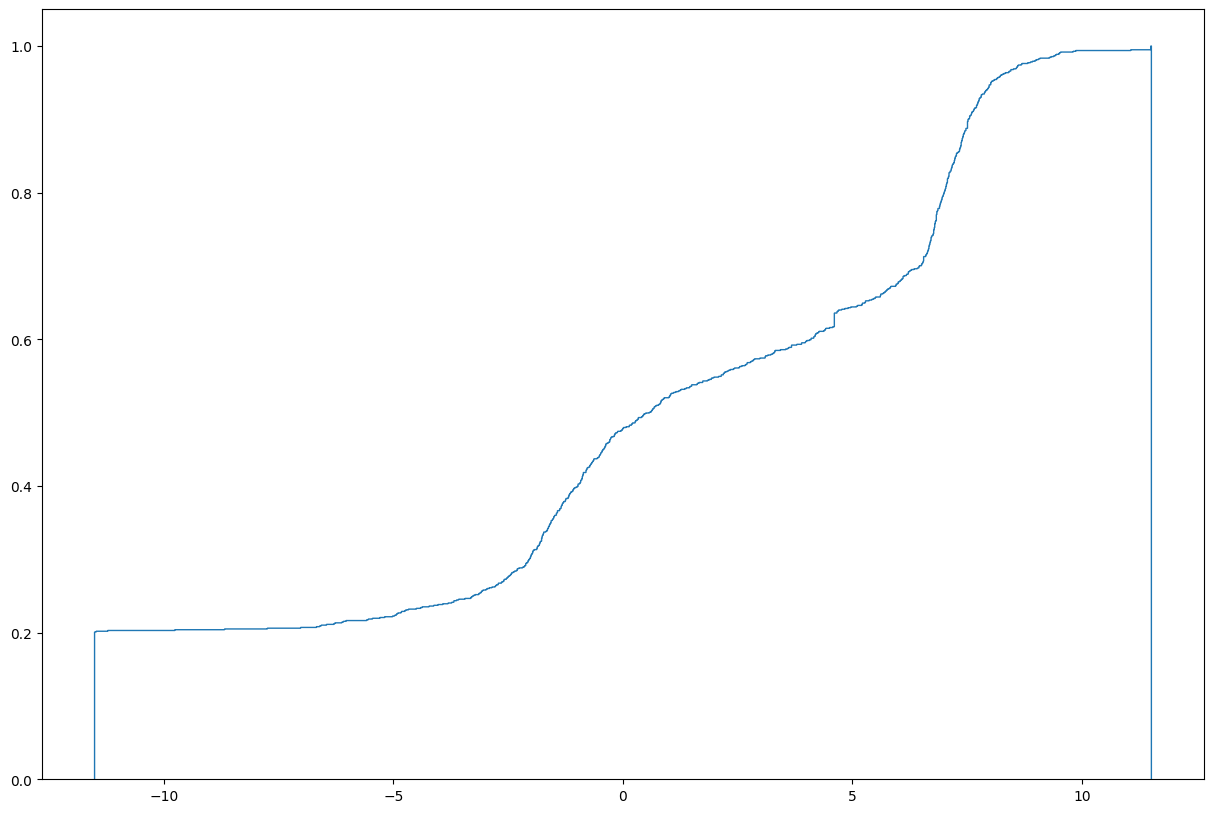

In [12]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=32,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=4,
    n_head=4,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=True,
).to(device)

model_path = "/content/1_var_set_transformer_expr_val.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym/ddim_step_1/1_var_set_transformer_expr_val.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)